In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from typing import Tuple, Dict
from sklearn.linear_model import LassoCV

In [ ]:


DATA_PATH = "data/spx_data_weekly.xlsx"

spx_df = pd.read_excel(DATA_PATH,sheet_name="spx data",header=[0, 1],index_col=0)
sector_df = pd.read_excel(DATA_PATH,sheet_name="sector data",header=[0, 1],index_col=0)
additional_df = pd.read_excel(DATA_PATH,sheet_name="additional data",header=[0, 1],index_col=0)

# Ensure dates sorted
spx_df = spx_df.sort_index()
sector_df = sector_df.sort_index()
additional_df = additional_df.sort_index()

# Convenience views
px_spx = spx_df.xs("PX_LAST", axis=1, level=1)          # stock prices
dy_spx = spx_df.xs("EQY_DVD_YLD_IND", axis=1, level=1)  # stock dividend yield
pe_spx = spx_df.xs("PE_RATIO", axis=1, level=1)         # PE Ratio

px_sector = sector_df.xs("PX_LAST", axis=1, level=1)    # sector prices
px_add = additional_df.xs("PX_LAST", axis=1, level=1)   # SPY, IEF, etc.

# Weekly returns
ret_spx = px_spx.pct_change()
ret_sector = px_sector.pct_change()
ret_add = px_add.pct_change()

spy_ret = ret_add["SPY"]  # market
spy_ret = spy_ret.rename("SPY")


date
2015-07-03         NaN
2015-07-10    0.000820
2015-07-17    0.024099
2015-07-24   -0.021084
2015-07-31    0.012019
                ...   
2025-05-30    0.017751
2025-06-06    0.016543
2025-06-13   -0.003572
2025-06-20   -0.001613
2025-06-27    0.034714
Name: SPY, Length: 522, dtype: float64


<p style="font-size:28px;">1. Data Processing </p>

In [30]:


MIN_WEEKS_5Y = 52 * 5


def max_consecutive_non_nan(series: pd.Series) -> int:

    mask = series.notna().to_numpy()
    if not mask.any():
        return 0

    max_run = 0
    current = 0
    for v in mask:
        if v:
            current += 1
            max_run = max(max_run, current)
        else:
            current = 0
    return max_run


def filter_tickers_with_5y_prices(price_df: pd.DataFrame,min_weeks: int = MIN_WEEKS_5Y) -> pd.Index:

    keep = []
    for ticker in price_df.columns:
        series = price_df[ticker]
        max_run = max_consecutive_non_nan(series)
        if max_run >= min_weeks:
            keep.append(ticker)
    return pd.Index(keep)


tickers_5y = filter_tickers_with_5y_prices(px_spx)
px_spx = px_spx[tickers_5y]
dy_spx = dy_spx[tickers_5y]
ret_spx = ret_spx[tickers_5y]

print(f"Tickers with >= 5 years continuous weekly data: {len(tickers_5y)}")



Tickers with >= 5 years continuous weekly data: 485


<p style="font-size:28px;">1.1. Data Processing </p>

In [31]:
results = []

# assuming valid_dates is built from the full panel, e.g.:
valid_dates = dy_spx.index

for t in valid_dates:
    # For each date, get the row of dividend yields and drop NaNs
    row = dy_spx.loc[t].dropna()   # <-- use full-data panel here

    # Ticker with highest and lowest yield on that date
    top = row.idxmax()
    bot = row.idxmin()

    results.append(
        {
            "date": t,
            "highest_ticker": top,
            "highest_yield": row[top],
            "lowest_ticker": bot,
            "lowest_yield": row[bot],
        }
    )

df_results = pd.DataFrame(results)

# Row with highest yield across ALL dates/tickers (panel-wide max)
row_highest = df_results.loc[df_results["highest_yield"].idxmax()]

# Row with lowest yield across ALL dates/tickers (panel-wide min)
row_lowest = df_results.loc[df_results["lowest_yield"].idxmin()]

print(
    f'Highest-yielding stock in the entire panel: '
    f'{row_highest["highest_ticker"]} on {row_highest["date"]}'
)
print(f'Dividend Yield: {row_highest["highest_yield"]:.4}\n')

print(
    f'Lowest-yielding stock in the entire panel: '
    f'{row_lowest["lowest_ticker"]} on {row_lowest["date"]}'
)
print(f'Dividend Yield: {row_lowest["lowest_yield"]:.4}')


Highest-yielding stock in the entire panel: TRGP on 2020-04-03 00:00:00
Dividend Yield: 64.8

Lowest-yielding stock in the entire panel: COO on 2021-09-03 00:00:00
Dividend Yield: 0.0132


In [6]:

dy_trailing_52 = dy_spx.rolling(window=52, min_periods=52).mean()
valid_dates = dy_trailing_52.dropna(how="all").index

last_date = dy_trailing_52.dropna(how="all").index[-1]
dy_last = dy_trailing_52.loc[last_date].dropna()

highest = dy_last.idxmax()
lowest = dy_last.idxmin()

print(f"Highest dividend-yielding stock (52-week average): {highest}")
print(f"Dividend Yield: {dy_last[highest]:.4f}\n")

print(f"Lowest dividend-yielding stock (52-week average): {lowest}")
print(f"Dividend Yield: {dy_last[lowest]:.4f}")


Highest dividend-yielding stock (52-week average): MO
Dividend Yield: 7.9489

Lowest dividend-yielding stock (52-week average): NVDA
Dividend Yield: 0.0318


**Was it driven more by changes in D or P?**</br>
TRGP's extreme yield is Price driven. COO’s small-yield is dividend driven, not price-driven. It pays negligible dividends, so the yield rounds down to zero. MO's high dividend yield is fundamentally dividend driven because the dividend payout is extremely large. NVDA's extremely low dividend yield is Price driven because the dividend is tiny and basically irrelevant.


<p style="font-size:28px;">1.2. A Carry Strategy & 1.3. Long-Short </p>

In [36]:


def top_20pct_dy_index(row: pd.Series, top_frac: float = 0.2):
    row = row.dropna()
    n = len(row)
    num =int(np.floor(top_frac * n))
    k_top = max(1,num)
    top_vals = row.nlargest(k_top)

    return top_vals.index

top_idx_per_date = dy_spx.apply(lambda row: top_20pct_dy_index(row, top_frac=0.2),axis=1)

prices_top20 = {}
weight =0.01

ret_fwd = ret_spx.shift(-1)


for date, tickers in top_idx_per_date.items():
    prices_top20[date] = ret_fwd.loc[date, tickers]
    
prices_top20_df = pd.DataFrame.from_dict(prices_top20, orient="index")* weight
prices_top20_df.index.name = "date"

row_means_top = prices_top20_df.sum(axis=1, skipna=True)

row_means_top.mean(skipna=True)*52
row_means_top


date
2015-07-03    0.004695
2015-07-10    0.004436
2015-07-17   -0.017047
2015-07-24    0.016680
2015-07-31   -0.005483
                ...   
2021-01-29    0.032593
2019-06-28    0.010548
2021-01-08    0.012939
2021-01-15   -0.005128
2021-01-22   -0.014260
Length: 522, dtype: float64

In [8]:
def bottom_20pct_dy_index(row: pd.Series, bottom_frac: float = 0.2):
    row = row.dropna()
    n = len(row)
    num = int(np.floor(bottom_frac * n))
    k_top = max(1, num)
    bottom_vals = row.nsmallest(k_top)
    return bottom_vals.index


bottom_idx_per_date = dy_spx.apply(
    lambda row: bottom_20pct_dy_index(row, bottom_frac=0.2),
    axis=1
)

prices_bottom20 = {}
weight =0.01
ret_fwd = ret_spx.shift(-1)

for date, tickers in bottom_idx_per_date.items():
    prices_bottom20[date] = ret_fwd.loc[date, tickers] 

prices_bottom20_df = pd.DataFrame.from_dict(prices_bottom20, orient="index") * weight
prices_bottom20_df.index.name = "date"

row_means_bottom = prices_bottom20_df.sum(axis=1, skipna=True)

ls_strat = row_means_top - row_means_bottom
ls_strat = ls_strat.dropna()
ls_mean_ann = ls_strat.mean() * 52

ls_mean_ann


np.float64(-0.00535091161501684)


<p style="font-size:28px;">1.4. Performance </p>

In [33]:

def portfolio_stats(ret: pd.Series,periods_per_year: int = 52) -> Dict[str, float]:

    ret = ret.dropna()

    mu_ann = ret.mean() * periods_per_year
    vol_ann = ret.std() * np.sqrt(periods_per_year)
    sharpe = mu_ann / vol_ann 

    skew = ret.skew()
    kurt=ret.kurtosis()
    sorted_ret=ret.sort_values()
    var_5 = sorted_ret.quantile(0.05)
    cvar_5 = sorted_ret[sorted_ret <= var_5].mean()

    value = (1 + ret).cumprod()
    peak = value.cummax()
    dd = (value / peak) - 1.0
    max_dd = dd.min()

    return {
        "ann_mean": mu_ann,
        "ann_vol": vol_ann,
        "sharpe": sharpe,
        "skew": skew,
        "Kurtosis":kurt,
        "VaR_5%": var_5,
        "CVaR_5%": cvar_5,
        "max_drawdown": max_dd,
    }


lo_ret = row_means_top          
ls_ret = ls_strat              


lo_stats = portfolio_stats(lo_ret)
ls_stats = portfolio_stats(ls_ret)
spy_stats = portfolio_stats(spy_ret)


stats_df = pd.DataFrame(
    {
        "LO": lo_stats,
        "LS": ls_stats,
        "SPY": spy_stats,
    }
).T  

stats_df



,ann_mean,ann_vol,sharpe,skew,Kurtosis,VaR_5%,CVaR_5%,max_drawdown
LO,0.111068,0.162514,0.683437,0.275737,18.709799,-0.028568,-0.049597,-0.360059
LS,-0.005351,0.095116,-0.056257,1.088621,8.584052,-0.018511,-0.027307,-0.240864
SPY,0.140826,0.173193,0.813116,-0.595027,5.881476,-0.033571,-0.056766,-0.318291


The long-only dividend yield strategy earns positive returns but still trails SPY on both performance and risk-adjusted metrics.
The long–short dividend yield spread has low volatility but delivers negative returns and a negative Sharpe, making it unattractive.
Overall, SPY clearly outperforms both strategies in return, consistency, and risk-adjusted performance.

<p style="font-size:28px;">2. Attribution </p>

In [ ]:
def ols_regression(y, X):
    if isinstance(X, pd.Series):
        if X.name is None:
            X = X.to_frame("X")
        else:
            X = X.to_frame(X.name)

    df = pd.concat([y, X], axis=1)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    y_clean = df.iloc[:, 0]
    X_clean = df.iloc[:, 1:]

    X_const = sm.add_constant(X_clean)
    model = sm.OLS(y_clean, X_const).fit()
    return model

spy_ret = spy_ret.rename("SPY")
spy_ret_fwd=spy_ret.shift(-1)

model_lo_spy = ols_regression(lo_ret, spy_ret_fwd)
model_ls_spy = ols_regression(ls_ret, spy_ret_fwd)
LO_alpha_ann_pct = model_lo_spy.params["const"] * 52 * 100
LO_beta_pct      = model_lo_spy.params["SPY"] * 100
LO_r2_pct        = model_lo_spy.rsquared * 100

LS_alpha_ann_pct = model_ls_spy.params["const"] * 52 * 100
LS_beta_pct      = model_ls_spy.params["SPY"] * 100
LS_r2_pct        = model_ls_spy.rsquared * 100

results_table = pd.DataFrame({
    "alpha_ann (%)": [LO_alpha_ann_pct, LS_alpha_ann_pct],
    "beta_SPY (%)":  [LO_beta_pct,      LS_beta_pct],
    "R2 (%)":        [LO_r2_pct,        LS_r2_pct]
},index=["Long-Only", "Long–Short"])

print(results_table.to_string(float_format="%.1f"))



            alpha_ann (%)  beta_SPY (%)  R2 (%)
Long-Only             0.4          75.9    65.3
Long–Short           -0.1          -2.9     0.3


In [49]:
def correlation_matrix(data):
    data_corr=data.corr()
    import matplotlib.pyplot as plt
    import seaborn as sns
    np.fill_diagonal(data_corr.values, np.nan)
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(
        data_corr,
        annot=True,        
        fmt=".2f",         
        vmin=-1, vmax=1,   
        square=True,       
        cbar_kws={"label": "Correlation"}
    )
    ax.set_title("Correlation Heatmap of Factors")
    plt.xticks(rotation=90, ha="center")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


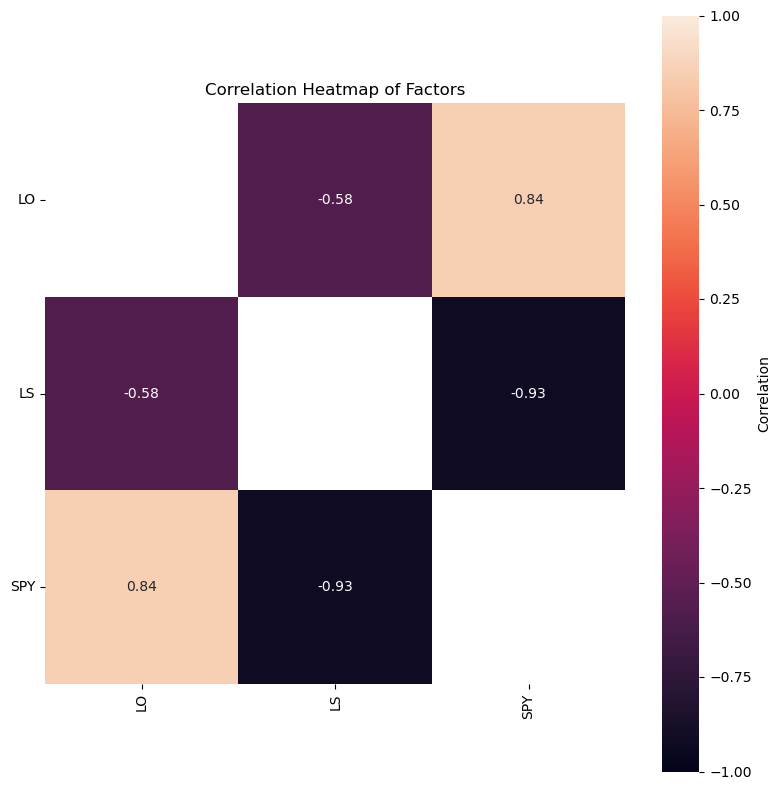

In [54]:
data = pd.concat(
    [
        lo_ret.rename("LO"),
        ls_ret.rename("LS"),
        spy_ret_fwd.rename("SPY"),
    ],
    axis=1,
    join="inner"
).dropna()

corr_mat = data.corr()

correlation_matrix(corr_mat)

The LO strategy moves closely with SPY (high beta, high R²) and behaves like a lower-beta version of the market with only a small positive alpha.
The LS strategy is almost completely market-neutral (near-zero beta, near-zero R²), meaning SPY doesn’t explain its returns at all.
Overall, SPY outperforms both, with LO offering diluted market exposure and LS offering diversification but no positive alpha.

In [ ]:


# 2.2 – Sector regression (LFD wrt sectors)

sector_rets = ret_sector.shift(-1) 

model_lo_sector = ols_regression(lo_ret, sector_rets)
model_ls_sector = ols_regression(ls_ret, sector_rets)

LO_alpha_ann_pct = model_lo_sector.params["const"] * 52 * 100
LS_alpha_ann_pct = model_ls_sector.params["const"] * 52 * 100

data = {
    "alpha_ann (%)": [LO_alpha_ann_pct, LS_alpha_ann_pct],
    "R2": [model_lo_sector.rsquared, model_ls_sector.rsquared],
}

for col in sector_rets.columns:
    lo_beta = model_lo_sector.params.get(col, float("nan")) * 100
    ls_beta = model_ls_sector.params.get(col, float("nan")) * 100
    data[f"beta_{col} (%)"] = [lo_beta, ls_beta]

table = pd.DataFrame(data, index=["Long-Only", "Long-Short"])

print(table.to_string(float_format="%.2f"))

            alpha_ann (%)   R2  beta_XLK (%)  beta_XLI (%)  beta_XLF (%)  beta_XLC (%)  beta_XLRE (%)  beta_XLE (%)  beta_XLY (%)  beta_XLB (%)  beta_XLV (%)  beta_XLU (%)  beta_XLP (%)
Long-Only            2.58 0.93        -10.00         10.39         24.44          6.31          25.40         12.23         -1.04          7.79         -6.72         12.67         -0.73
Long-Short           2.15 0.64        -24.75        -13.32         20.75          5.13          21.57         11.01         -9.99          0.10        -24.11         14.28          3.51


Neither LO nor LS is sector-neutral — both show strong, persistent sector tilts.

The largest exposures for both are to Real Estate (XLRE) and Financials (XLF), with LS also heavily short Tech (XLK) and Healthcare (XLV). Because regressors aren’t standardized, absolute beta magnitudes are an approximation.

In [61]:
# 2.4 – MAG portfolio & two-factor regression (SPY + MAG)

MAG_TICKERS = ["AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "META", "TSLA"]
common_mag = [t for t in MAG_TICKERS if t in ret_spx.columns]

mag_ret = ret_spx[common_mag].mean(axis=1)
mag_ret = mag_ret.rename("MAG")
mag_ret_fwd = mag_ret.shift(-1)

spy_ret = spy_ret.rename("SPY")
spy_ret_fwd = spy_ret.shift(-1)

X_lo_2f = pd.concat([spy_ret_fwd, mag_ret_fwd], axis=1)
X_ls_2f = pd.concat([spy_ret_fwd, mag_ret_fwd], axis=1)

model_lo_2f = ols_regression(lo_ret, X_lo_2f)
model_ls_2f = ols_regression(ls_ret, X_ls_2f)

# Alpha (annualised, %)
LO_alpha_ann_pct = model_lo_2f.params["const"] * 52 * 100
LS_alpha_ann_pct = model_ls_2f.params["const"] * 52 * 100

data = {
    "alpha_ann (%)": [LO_alpha_ann_pct,        LS_alpha_ann_pct],
    "R2":            [model_lo_2f.rsquared,    model_ls_2f.rsquared],
}

# Betas for SPY and MAG (in %)
for col in X_lo_2f.columns:  # should be ["SPY", "MAG"]
    lo_beta = model_lo_2f.params.get(col, float("nan")) * 100
    ls_beta = model_ls_2f.params.get(col, float("nan")) * 100
    data[f"beta_{col} (%)"] = [lo_beta, ls_beta]

table = pd.DataFrame(data, index=["Long-Only", "Long-Short"])
print(table.to_string(float_format="%.2f"))

            alpha_ann (%)   R2  beta_SPY (%)  beta_MAG (%)
Long-Only            6.64 0.77        122.01        -36.28
Long-Short           4.63 0.20         32.48        -27.84


The LO strategy is heavily driven by market risk (beta > 1) and strongly short MAG stocks. The LS strategy has lower market exposure but is still substantially short MAG. Overall, both strategies load heavily on SPY and MAG, so their returns partly reflect these factor bets rather than pure dividend-yield carry.

<p style="font-size:28px;">3. Dynamic hedged </p>

In [85]:

def rolling_sector_betas(ret, sector_rets, window=260):

    betas = []
    idx = sector_rets.index

    for t in range(len(idx)):

        if t < window:
            betas.append(pd.Series(np.nan, index=sector_rets.columns))
            continue

        y = ret.loc[idx[t-window:t-1]]
        X = sector_rets.loc[idx[t-window:t-1]]

        df = pd.concat([y, X], axis=1).dropna()
        if df.empty:
            betas.append(pd.Series(np.nan, index=sector_rets.columns))
            continue

        y_clean = df.iloc[:, 0]
        X_clean = df.iloc[:, 1:]
        X_const = sm.add_constant(X_clean)

        model = sm.OLS(y_clean, X_const).fit()
        betas.append(model.params.drop("const"))

    return pd.DataFrame(betas, index=sector_rets.index)


def sector_hedged_returns(ret, sector_rets, betas):

    hedge_component = (betas * sector_rets).sum(axis=1)
    hedged = ret - hedge_component
    return hedged

def portfolio_stats(ret):
    ret = ret.dropna()
    periods_per_year = 52

    mu_ann = ret.mean() * periods_per_year *  100
    vol_ann = ret.std() * np.sqrt(periods_per_year) *100
    sharpe = mu_ann / vol_ann 
    return {
        "Annualized Mean": mu_ann,
        "Annualized vol": vol_ann,
        "Sharpe": sharpe
    }

lo_betas = rolling_sector_betas(lo_ret, sector_rets)
ls_betas = rolling_sector_betas(ls_ret, sector_rets)


lo_hedged = sector_hedged_returns(lo_ret, sector_rets, lo_betas)
ls_hedged = sector_hedged_returns(ls_ret, sector_rets, ls_betas)

lo_hedged_stats = portfolio_stats(lo_hedged)
ls_hedged_stats = portfolio_stats(ls_hedged)

hedged_table = pd.DataFrame(
    [lo_hedged_stats, ls_hedged_stats],
    index=["Long-Only (Hedged)", "Long-Short (Hedged)"]
)

print(hedged_table.to_string(float_format="%.5f"))


                     Annualized Mean  Annualized vol   Sharpe
Long-Only (Hedged)           3.89354        13.68360  0.28454
Long-Short (Hedged)         -1.72405         8.14259 -0.21173


                     ann_mean  ann_vol  sharpe   skew  Kurtosis  VaR_5%  CVaR_5%  max_drawdown
Long-Only (Hedged)    -0.0157   0.0501 -0.3136 0.2028    0.3442 -0.0106  -0.0131       -0.0664
Long-Short (Hedged)   -0.0324   0.0668 -0.4846 0.2810   -0.1378 -0.0132  -0.0173       -0.0940


<p style="font-size:28px;">4. Assessing the Forecast </p>

In [ ]:


# 4.1 – Forecast vs raw returns

def build_forecasts(
    dy_trailing: pd.DataFrame,
    top_frac: float = 0.2,
    bottom_frac: float = 0.2,
    pos_forecast: float = 0.001,
    neg_forecast: float = -0.001,
) -> pd.DataFrame:
    """
    For each date t, mark:
      +pos_forecast for top_frac names,
      neg_forecast for bottom_frac names,
      0 otherwise.
    """
    forecasts = pd.DataFrame(
        0.0, index=dy_trailing.index, columns=dy_trailing.columns
    )

    for t in dy_trailing.index:
        dy_t = dy_trailing.loc[t]
        dy_t = dy_t.dropna()
        if dy_t.empty:
            continue

        n = len(dy_t)
        k_top = max(1, int(np.floor(top_frac * n)))
        k_bot = max(1, int(np.floor(bottom_frac * n)))

        top = dy_t.nlargest(k_top).index
        bottom = dy_t.nsmallest(k_bot).index

        forecasts.loc[t, top] = pos_forecast
        forecasts.loc[t, bottom] = neg_forecast

    return forecasts


forecasts = build_forecasts(dy_trailing_52)

# Align forecasts at t with returns at t+1
common_dates = forecasts.index.intersection(ret_spx.index)
common_dates = common_dates.sort_values()

f_list = []
r_list = []

for i in range(len(common_dates) - 1):
    t = common_dates[i]
    t_next = common_dates[i + 1]
    f_t = forecasts.loc[t]
    r_tp1 = ret_spx.loc[t_next]

    # keep tickers with non-zero forecast and non-NaN return
    mask = (f_t != 0.0) & r_tp1.notna()
    if not mask.any():
        continue

    f_list.append(f_t[mask].to_numpy())
    r_list.append(r_tp1[mask].to_numpy())

if f_list:
    f_all = np.concatenate(f_list)
    r_all = np.concatenate(r_list)

    corr_fr = np.corrcoef(f_all, r_all)[0, 1]
    # R^2 from simple regression r = beta f (no intercept)
    beta = np.dot(f_all, r_all) / np.dot(f_all, f_all)
    r_hat = beta * f_all
    ss_res = np.sum((r_all - r_hat) ** 2)
    ss_tot = np.sum((r_all - r_all.mean()) ** 2)
    r2_forecast = 1 - ss_res / ss_tot

    print("Forecast vs raw returns corr:", corr_fr)
    print("Forecast vs raw returns R2:", r2_forecast)
else:
    print("No f_list – check data alignment for forecasts vs raw returns.")


# 4.2 – Forecast vs SPY-hedged residuals

def stock_betas_vs_spy(
    ret_stock: pd.DataFrame,
    spy_ret: pd.Series,
) -> pd.Series:
    """
    Estimate a single beta for each stock vs SPY over entire sample (simple).
    """
    betas = {}
    for ticker in ret_stock.columns:
        combined = pd.concat(
            [ret_stock[ticker].rename("r"), spy_ret.rename("spy")],
            axis=1,
        ).dropna()
        if len(combined) < 50:
            continue
        X = sm.add_constant(combined["spy"])
        model = sm.OLS(combined["r"], X).fit()
        betas[ticker] = model.params["spy"]
    return pd.Series(betas)


betas_spy = stock_betas_vs_spy(ret_spx, spy_ret)
betas_spy = betas_spy.reindex(ret_spx.columns).fillna(0.0)

# Compute residuals epsilon_{i,t} = r_{i,t} - beta_i * spy_t
eps_spx = ret_spx.sub(spy_ret, axis=0).mul(betas_spy, axis=1)  # wrong: need broadcasting carefully

# Correct residual: r_i,t - beta_i * spy_t
# We'll recompute properly:
eps_spx = ret_spx.copy()
for ticker in eps_spx.columns:
    eps_spx[ticker] = ret_spx[ticker] - betas_spy[ticker] * spy_ret

# Now align forecasts at t with eps at t+1
fe_list = []
e_list = []

for i in range(len(common_dates) - 1):
    t = common_dates[i]
    t_next = common_dates[i + 1]

    f_t = forecasts.loc[t]
    e_tp1 = eps_spx.loc[t_next]

    mask = (f_t != 0.0) & e_tp1.notna()
    if not mask.any():
        continue

    fe_list.append(f_t[mask].to_numpy())
    e_list.append(e_tp1[mask].to_numpy())

if fe_list:
    f_all = np.concatenate(fe_list)
    e_all = np.concatenate(e_list)

    corr_fe = np.corrcoef(f_all, e_all)[0, 1]
    beta_fe = np.dot(f_all, e_all) / np.dot(f_all, f_all)
    e_hat = beta_fe * f_all
    ss_res = np.sum((e_all - e_hat) ** 2)
    ss_tot = np.sum((e_all - e_all.mean()) ** 2)
    r2_fe = 1 - ss_res / ss_tot

    print("Forecast vs SPY-hedged residuals corr:", corr_fe)
    print("Forecast vs SPY-hedged residuals R2:", r2_fe)
else:
    print("No fe_list – check data alignment for forecasts vs residuals.")


# 4.3 – Forecast vs sector-hedged residuals

def stock_betas_vs_sectors(
    ret_stock: pd.DataFrame,
    ret_sector: pd.DataFrame,
) -> pd.DataFrame:
    """
    Estimate one beta vector per stock vs all sectors, using full sample.
    Returns DataFrame: index=tickers, columns=sector ETFs.
    """
    betas_dict = {}
    for ticker in ret_stock.columns:
        combined = pd.concat(
            [ret_stock[ticker].rename("r"), ret_sector],
            axis=1,
        ).dropna()
        if len(combined) < 50:
            continue
        y = combined["r"]
        X = combined[ret_sector.columns]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        betas_t = model.params.drop("const")
        betas_dict[ticker] = betas_t
    beta_df = pd.DataFrame(betas_dict).T
    return beta_df


beta_sectors = stock_betas_vs_sectors(ret_spx, ret_sector)
beta_sectors = beta_sectors.reindex(index=ret_spx.columns, columns=ret_sector.columns).fillna(0.0)

# Residuals u_{i,t} = r_{i,t} - sum_j beta_{ij} * sector_j,t
u_spx = pd.DataFrame(index=ret_spx.index, columns=ret_spx.columns, dtype=float)

for ticker in ret_spx.columns:
    r_i = ret_spx[ticker]
    b_i = beta_sectors.loc[ticker]
    # hedged component
    hedged_i = (ret_sector * b_i).sum(axis=1)
    u_spx[ticker] = r_i - hedged_i

fs_list = []
u_list = []

for i in range(len(common_dates) - 1):
    t = common_dates[i]
    t_next = common_dates[i + 1]

    f_t = forecasts.loc[t]
    u_tp1 = u_spx.loc[t_next]

    mask = (f_t != 0.0) & u_tp1.notna()
    if not mask.any():
        continue

    fs_list.append(f_t[mask].to_numpy())
    u_list.append(u_tp1[mask].to_numpy())

if fs_list:
    f_all = np.concatenate(fs_list)
    u_all = np.concatenate(u_list)

    corr_fu = np.corrcoef(f_all, u_all)[0, 1]
    beta_fu = np.dot(f_all, u_all) / np.dot(f_all, f_all)
    u_hat = beta_fu * f_all
    ss_res = np.sum((u_all - u_hat) ** 2)
    ss_tot = np.sum((u_all - u_all.mean()) ** 2)
    r2_fu = 1 - ss_res / ss_tot

    print("Forecast vs sector-hedged residuals corr:", corr_fu)
    print("Forecast vs sector-hedged residuals R2:", r2_fu)
else:
    print("No fs_list – check data alignment for forecasts vs sector residuals.")


Forecast vs raw returns corr: -0.008731231153207246
Forecast vs raw returns R2: -0.004712222544838829
Forecast vs SPY-hedged residuals corr: -0.00814064412373235
Forecast vs SPY-hedged residuals R2: 6.570341231737498e-05
Forecast vs sector-hedged residuals corr: -0.006056369966100719
Forecast vs sector-hedged residuals R2: -0.0002183342115611442


In [34]:


# 1. Choose a target asset
TARGET = "AAPL"

# 2. Build regression dataset for LASSO:
#    y_t = r_target,t ; X_t = returns of all OTHER stocks at t
ret_all = ret_spx.dropna(how="all")
y = ret_all[TARGET]
X = ret_all.drop(columns=[TARGET])

combined = pd.concat([y.rename("y"), X], axis=1).dropna()
y_clean = combined["y"].values
X_clean = combined.drop(columns=["y"]).values

print("LASSO sample shape:", X_clean.shape)  # (T, N-1)

# 3. Fit LASSO with CV (sparse replication portfolio)
lasso_cv = LassoCV(cv=5, random_state=0, max_iter=10000)
lasso_cv.fit(X_clean, y_clean)

alpha_opt = lasso_cv.alpha_
coef = pd.Series(lasso_cv.coef_, index=X.columns)
nonzero_weights = coef[coef != 0.0]

print("Optimal alpha:", alpha_opt)
print("Number of non-zero exposures:", len(nonzero_weights))

# In-sample fit quality
r2 = lasso_cv.score(X_clean, y_clean)
y_hat = lasso_cv.predict(X_clean)
residuals = y_clean - y_hat
print("R^2 of replication:", r2)
print("Tracking error (weekly std of residuals):", residuals.std())

# 4. Build forecast series for target vs replication portfolio

# Dates where we have trailing yield (for forecast) and returns
idx_common = dy_trailing_52.index.intersection(ret_all.index)
# Require AAPL to have a non-null trailing yield
mask_dates = idx_common[dy_trailing_52.loc[idx_common, TARGET].notna()]

# Target forecasts f_target(t) = forecast for AAPL at t
f_target = forecasts.loc[mask_dates, TARGET]

# Replication portfolio uses only non-zero LASSO weights
rep_tickers = nonzero_weights.index
w = nonzero_weights

# f_rep(t) = sum_j w_j * f_j(t)
f_rep = (forecasts.loc[mask_dates, rep_tickers] * w).sum(axis=1)

# 5. Compare the two forecast series
corr_forecast = np.corrcoef(f_target, f_rep)[0, 1]
diff = f_target - f_rep

print("Forecast correlation (target vs replication):", corr_forecast)
print("Mean forecast difference (weekly, target - rep):", diff.mean())
print("Std of forecast difference (weekly):", diff.std())

# Convert mean difference to annual % (since 0.001 ≈ 0.1% per week)
mean_diff_annual_pct = diff.mean() * 52 * 100
print("Mean forecast difference annualized (percentage points):",
      mean_diff_annual_pct)


LASSO sample shape: (260, 484)
Optimal alpha: 6.660302154539462e-05
Number of non-zero exposures: 59
R^2 of replication: 0.7321461946817996
Tracking error (weekly std of residuals): 0.020140311988592972
Forecast correlation (target vs replication): 0.7545083753136952
Mean forecast difference (weekly, target - rep): -0.0005700514056049021
Std of forecast difference (weekly): 0.00041049110072449143
Mean forecast difference annualized (percentage points): -2.964267309145491
